### Modules for import & function definition

In [15]:
import sys
import os

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.patches as mpatches
import matplotlib.gridspec as gridspec

import seaborn as sns

import numpy as np
import pandas as pd
import netCDF4 as nc
import datetime

def aux_df(dataframe): # creating columns for auxillary (constructed) variables
                       # such as NEE, RECO, and EET:PET
    dataframe['RECO'] = dataframe['RG'] + dataframe['RH'] + dataframe['RM']
    dataframe['NEE'] = dataframe['GPP'] - dataframe['RECO']
    dataframe['EET/PET'] = dataframe['EET']/dataframe['PET']
    return

def layer_interp(Var, Depth, Thickness, resolution):
    
    df_interp = pd.DataFrame(index=Var.index, columns=range(resolution), data=[])

    for date in Var.index:
        
        xp = Depth.loc[date] + Thickness.loc[date]/2
        x=np.linspace(min(xp), max(xp), resolution)
        fp = Var.loc[date]
        
        df_interp.loc[date]=np.interp(x,xp,fp)
        
    # fig, ax = plt.subplots()
    # ax.pcolor(df_interp.index, -x, np.transpose(df_interp.values.astype(float)))
    
    df_interp.columns = x
    
    return df_interp.replace(-9999.0, np.nan)

def temp_interp(time1, time2, T1, T2, D1, D2, Dnew):
    
    temp_new = []
    
    for i in range (0, len(T1[time1:time2])):
        
        temp_new.append(np.interp(Dnew, [D1, D2], [T1[time1:time2][i], T2[time1:time2][i]]))
   
    return temp_new

def seasonal_profile(VAR, depth, thickness, resolution, time_range, months):
    '''
    VAR : variable dataframe
    depth : associated LAYERDEPTH dataframe
    thickness : associated LAYERDZ dataframe
    resolution : total number of points to interpolate through soil column
    time_range : time period to be calculated over (e.g. '2011-2021')
    months : months included in calculation - ['Jan', 'Feb', 'Dec'] (e.g winter season)
    '''
    month_range = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

    startyr, endyr = time_range.split('-')

    #Setting time range    
    range_series = VAR[startyr:endyr]
    LD = depth[startyr:endyr]
    LZ = thickness[startyr:endyr]

    #Seasonal exclusion
    range_series = range_series[range_series.index.month.isin([i+1 for i, e in enumerate(month_range) if e in months])]
    LD = (LD[LD.index.month.isin([i+1 for i, e in enumerate(month_range) if e in months])]).mean()
    LZ = (LZ[LZ.index.month.isin([i+1 for i, e in enumerate(month_range) if e in months])]).mean()
    mean = range_series.mean().values.tolist()
    maxi = range_series.max().values.tolist()
    mini = range_series.min().values.tolist()
    std =  range_series.std().values.tolist()

    xp = (LD + LZ/2).values.tolist()
    for i in range(0, len(xp)):
        if xp[i]<0.0:
            xp.remove(xp[i])
            mean.remove(mean[i])
            mini.remove(mini[i])
            maxi.remove(maxi[i])
            std.remove(std[i])
            
    x = np.linspace(min(xp), max(xp), resolution)

    interp_mean=np.interp(x,xp,mean)
    interp_mini=np.interp(x,xp,mini)
    interp_maxi=np.interp(x,xp,maxi)
    interp_std=np.interp(x,xp,std)
    
    return x,interp_mean, interp_std, interp_mini, interp_maxi

sys.path.insert(0, '/work/scripts')

from output_utils import load_trsc_dataframe

In [2]:
ls /data/workflows/layer_scheme_test/test_olt/1layer/output

ALD_yearly_sc.nc             RAINFALL_monthly_sc.nc
ALD_yearly_sp.nc             RAINFALL_monthly_sp.nc
ALD_yearly_tr.nc             RAINFALL_monthly_tr.nc
AVLN_monthly_sc.nc           RG_monthly_sc.nc
AVLN_monthly_sp.nc           RG_monthly_sp.nc
AVLN_monthly_tr.nc           RG_monthly_tr.nc
CMTNUM_yearly_sc.nc          RH_monthly_sc.nc
CMTNUM_yearly_sp.nc          RH_monthly_sp.nc
CMTNUM_yearly_tr.nc          RH_monthly_tr.nc
DEEPC_monthly_sc.nc          RM_monthly_sc.nc
DEEPC_monthly_sp.nc          RM_monthly_sp.nc
DEEPC_monthly_tr.nc          RM_monthly_tr.nc
DEEPDZ_monthly_sc.nc         ROOTWATERUPTAKE_monthly_sc.nc
DEEPDZ_monthly_sp.nc         ROOTWATERUPTAKE_monthly_sp.nc
DEEPDZ_monthly_tr.nc         ROOTWATERUPTAKE_monthly_tr.nc
EET_monthly_sc.nc            SHLWC_monthly_sc.nc
EET_monthly_sp.nc            SHLWC_monthly_sp.nc
EET_monthly_tr.nc            SHLWC_monthly_tr.nc
GPP_monthly_sc.nc            SHLWDZ_monthly_sc.nc
GPP_monthly_sp.nc            SHLWDZ_monthly_sp.nc
GPP_mo

### List of directories to read

In [3]:
base_dir = "/data/workflows/layer_scheme_test/"
olt_dir = "test_olt/"

f_dir = [
    olt_dir+"1layer",
    olt_dir+"2layer",
    olt_dir+"3layer",
    olt_dir+"4layer",
    olt_dir+"5layer",
    olt_dir+"6layer",
    olt_dir+"7layer",
    olt_dir+"8layer",
    olt_dir+"9layer"
    
        ]

f_name = [
    "1 layer",
    "2 layers",
    "3 layers",
    "4 layers",
    "5 layers",
    "6 layers",
    "7 layers",
    "8 layers",
    "9 layers"
]

In [4]:
units = {}
dfs_y = [];dfs_m = []

yearly_vars = ["ALD", "CMTNUM"]

monthly_vars = ['SHLWDZ','DEEPDZ', 'GPP', 'AVLN', 'DEEPC', 'EET','QDRAINAGE', 'QINFILTRATION', 'SOMPR', 'SOMRAWC', 'VEGC', 'INGPP',
            'QRUNOFF', 'RG', 'RH', 'RM','WATERTAB', 'PET', 'SHLWC', 'MINEC', 'SOMA', 'SOMCR', 'SNOWTHICK', 'HKLAYER']

layer_vars = ["LAYERDZ", "LAYERDEPTH", "LAYERTYPE", "VWCLAYER", "TLAYER"]
layer_data = {key: [] for key in layer_vars}
soil_vars = ["ground", "moss", "shlw", "deep", "mine"]
soil_profiles = {key: [] for key in soil_vars}

for i, DIR in enumerate(f_dir):
    
    df = pd.DataFrame()
    
    os.chdir(base_dir+DIR)
    
    for VAR in yearly_vars:
        
        dfa, meta = load_trsc_dataframe(var=VAR, timeres='yearly', px_y=0,
                                   px_x=1, fileprefix='output')
        if dfa.columns.stop>1:
            dfa = pd.DataFrame(dfa.sum(axis=1))
        dfa.columns = [VAR];df = pd.concat([df,dfa], axis=1)
        
        if f_dir.index(DIR)==0:
            
            units[VAR]=meta['var_units']
        
    dfs_y.append(df)
    
    df = pd.DataFrame()
    
    for VAR in monthly_vars:
        
        dfa, meta = load_trsc_dataframe(var=VAR, timeres='monthly', px_y=0,
                                   px_x=1, fileprefix='output')
        if dfa.columns.stop>1:
            dfa = pd.DataFrame(dfa.sum(axis=1))
        dfa.columns = [VAR];df = pd.concat([df,dfa], axis=1)

        if f_dir.index(DIR)==0:
            
            units[VAR]=meta['var_units']
            
    aux_df(df)
    units["NEE"]=units["GPP"];units["RECO"]=units["GPP"];units["EET/PET"]=" "
    dfs_m.append(df)
       
    for VAR in layer_vars:
        
        if VAR == "":
            dfa, meta = load_trsc_dataframe(var=VAR, timeres='yearly', px_y=0,
                                             px_x=1, fileprefix='output')
            layer_data[VAR] += [dfa]
        else:
            dfa, meta = load_trsc_dataframe(var=VAR, timeres='monthly', px_y=0,
                                                 px_x=1, fileprefix='output')
            layer_data[VAR] += [dfa]

        if f_dir.index(DIR)==0:
            
            units[VAR]=meta['var_units']
            
    ground = layer_data["LAYERDEPTH"][i][0]        
    soil_profiles["ground"] += [pd.DataFrame({"ground":ground})]
    
    moss = ground - (layer_data["LAYERDZ"][i].iloc[:,layer_data["LAYERTYPE"][i][:1]
                    .apply(lambda x: layer_data["LAYERTYPE"][i][:1].columns[x==0], axis = 1)
                    .values[0]].sum(axis=1))
    soil_profiles["moss"] += [pd.DataFrame({"moss":moss})]
    
    shlw = moss - (layer_data["LAYERDZ"][i].iloc[:,layer_data["LAYERTYPE"][i][:1]
                    .apply(lambda x: layer_data["LAYERTYPE"][i][:1].columns[x==1], axis = 1)
                    .values[0]].sum(axis=1))
    soil_profiles["shlw"] += [pd.DataFrame({"shlw":shlw})]
    
    deep = shlw - (layer_data["LAYERDZ"][i].iloc[:,layer_data["LAYERTYPE"][i][:1]
                    .apply(lambda x: layer_data["LAYERTYPE"][i][:1].columns[x==2], axis = 1)
                    .values[0]].sum(axis=1))
    soil_profiles["deep"] += [pd.DataFrame({"deep":deep})]
    
    mine = deep - (layer_data["LAYERDZ"][i].iloc[:,layer_data["LAYERTYPE"][i][:1]
                    .apply(lambda x: layer_data["LAYERTYPE"][i][:1].columns[x==3], axis = 1)
                    .values[0]].sum(axis=1))
    soil_profiles["mine"] += [pd.DataFrame({"mine":mine})]
    

Trying to open:  output/ALD_yearly_tr.nc
Trying to open:  output/ALD_yearly_sc.nc
Trying to open:  output/CMTNUM_yearly_tr.nc
Trying to open:  output/CMTNUM_yearly_sc.nc
Trying to open:  output/SHLWDZ_monthly_tr.nc
Trying to open:  output/SHLWDZ_monthly_sc.nc
Trying to open:  output/DEEPDZ_monthly_tr.nc
Trying to open:  output/DEEPDZ_monthly_sc.nc
Trying to open:  output/GPP_monthly_tr.nc
Trying to open:  output/GPP_monthly_sc.nc
Trying to open:  output/AVLN_monthly_tr.nc
Trying to open:  output/AVLN_monthly_sc.nc
Trying to open:  output/DEEPC_monthly_tr.nc
Trying to open:  output/DEEPC_monthly_sc.nc
Trying to open:  output/EET_monthly_tr.nc
Trying to open:  output/EET_monthly_sc.nc
Trying to open:  output/QDRAINAGE_monthly_tr.nc
Trying to open:  output/QDRAINAGE_monthly_sc.nc
Trying to open:  output/QINFILTRATION_monthly_tr.nc
Trying to open:  output/QINFILTRATION_monthly_sc.nc
Trying to open:  output/SOMPR_monthly_tr.nc
Trying to open:  output/SOMPR_monthly_sc.nc
Trying to open:  out

Trying to open:  output/DEEPDZ_monthly_tr.nc
Trying to open:  output/DEEPDZ_monthly_sc.nc
Trying to open:  output/GPP_monthly_tr.nc
Trying to open:  output/GPP_monthly_sc.nc
Trying to open:  output/AVLN_monthly_tr.nc
Trying to open:  output/AVLN_monthly_sc.nc
Trying to open:  output/DEEPC_monthly_tr.nc
Trying to open:  output/DEEPC_monthly_sc.nc
Trying to open:  output/EET_monthly_tr.nc
Trying to open:  output/EET_monthly_sc.nc
Trying to open:  output/QDRAINAGE_monthly_tr.nc
Trying to open:  output/QDRAINAGE_monthly_sc.nc
Trying to open:  output/QINFILTRATION_monthly_tr.nc
Trying to open:  output/QINFILTRATION_monthly_sc.nc
Trying to open:  output/SOMPR_monthly_tr.nc
Trying to open:  output/SOMPR_monthly_sc.nc
Trying to open:  output/SOMRAWC_monthly_tr.nc
Trying to open:  output/SOMRAWC_monthly_sc.nc
Trying to open:  output/VEGC_monthly_tr.nc
Trying to open:  output/VEGC_monthly_sc.nc
Trying to open:  output/INGPP_monthly_tr.nc
Trying to open:  output/INGPP_monthly_sc.nc
Trying to open

Trying to open:  output/AVLN_monthly_tr.nc
Trying to open:  output/AVLN_monthly_sc.nc
Trying to open:  output/DEEPC_monthly_tr.nc
Trying to open:  output/DEEPC_monthly_sc.nc
Trying to open:  output/EET_monthly_tr.nc
Trying to open:  output/EET_monthly_sc.nc
Trying to open:  output/QDRAINAGE_monthly_tr.nc
Trying to open:  output/QDRAINAGE_monthly_sc.nc
Trying to open:  output/QINFILTRATION_monthly_tr.nc
Trying to open:  output/QINFILTRATION_monthly_sc.nc
Trying to open:  output/SOMPR_monthly_tr.nc
Trying to open:  output/SOMPR_monthly_sc.nc
Trying to open:  output/SOMRAWC_monthly_tr.nc
Trying to open:  output/SOMRAWC_monthly_sc.nc
Trying to open:  output/VEGC_monthly_tr.nc
Trying to open:  output/VEGC_monthly_sc.nc
Trying to open:  output/INGPP_monthly_tr.nc
Trying to open:  output/INGPP_monthly_sc.nc
Trying to open:  output/QRUNOFF_monthly_tr.nc
Trying to open:  output/QRUNOFF_monthly_sc.nc
Trying to open:  output/RG_monthly_tr.nc
Trying to open:  output/RG_monthly_sc.nc
Trying to open

In [5]:
shlw

1901-01-01   -0.26
1901-02-01   -0.26
1901-03-01   -0.26
1901-04-01   -0.26
1901-05-01   -0.26
              ... 
2100-08-01   -0.26
2100-09-01   -0.26
2100-10-01   -0.26
2100-11-01   -0.26
2100-12-01   -0.26
Freq: MS, Length: 2400, dtype: float64

# Soil profiles

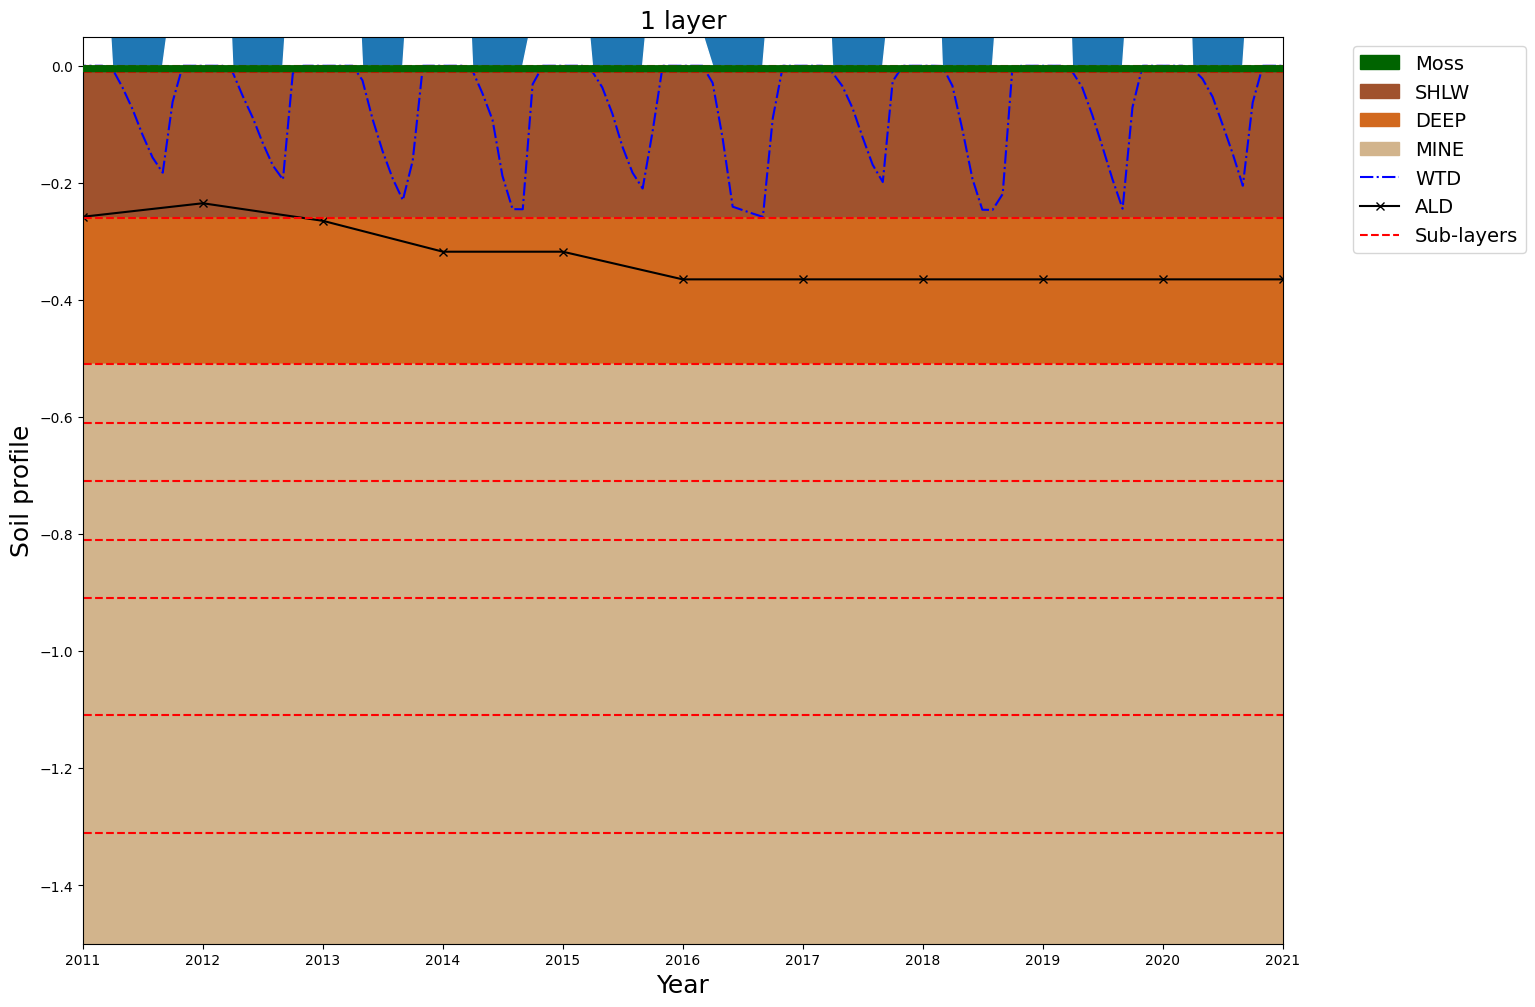

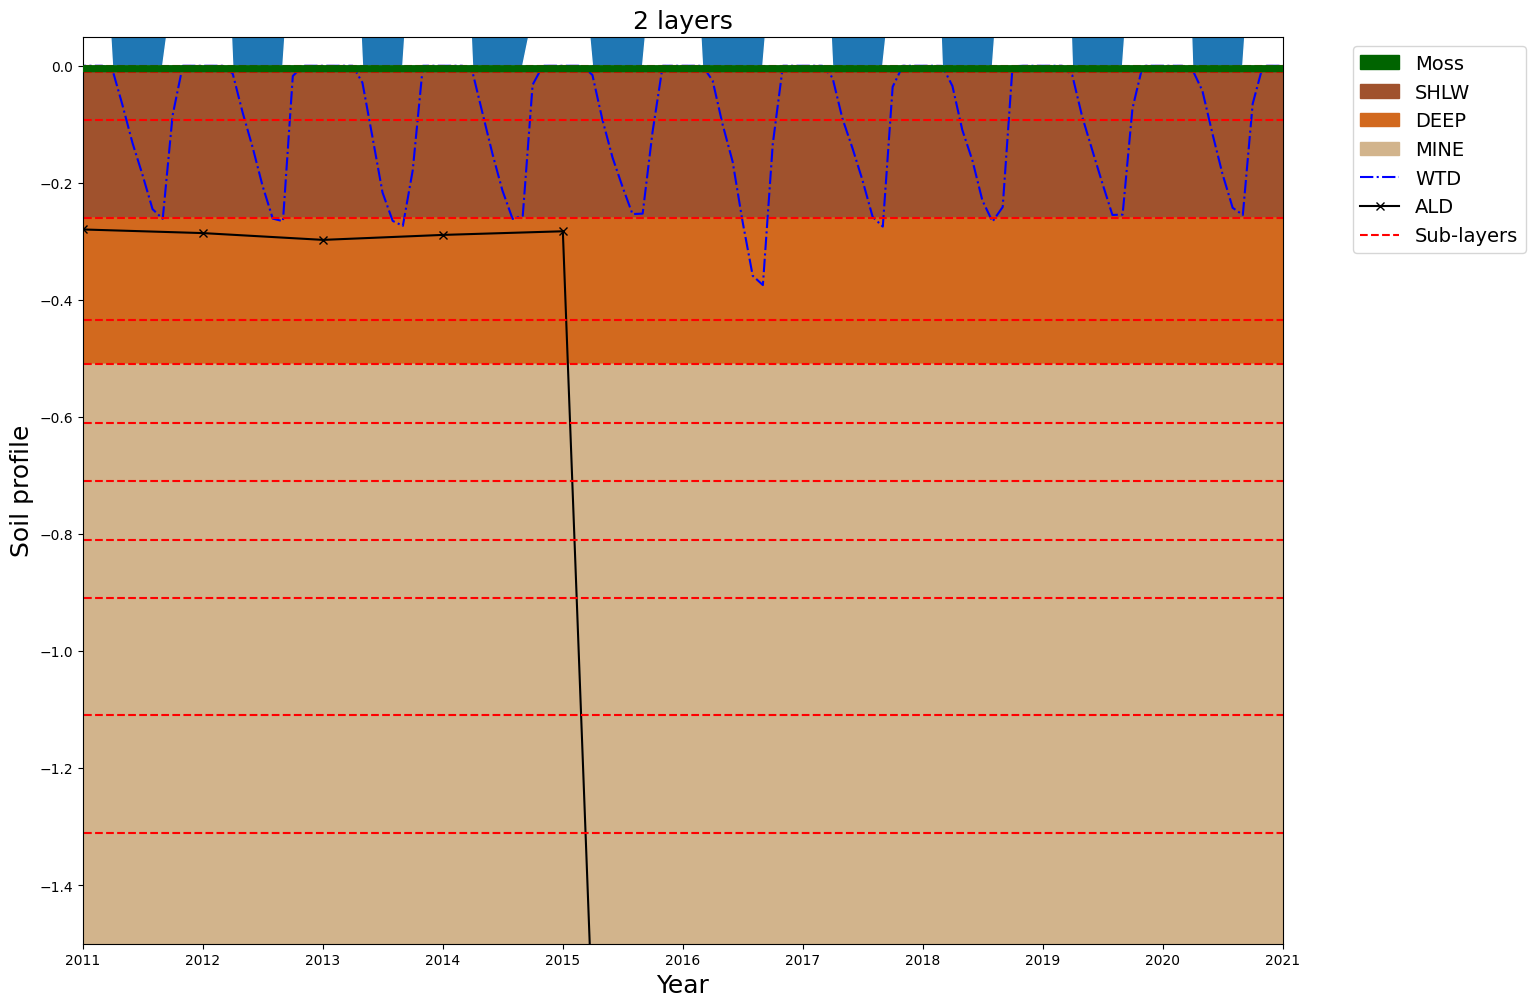

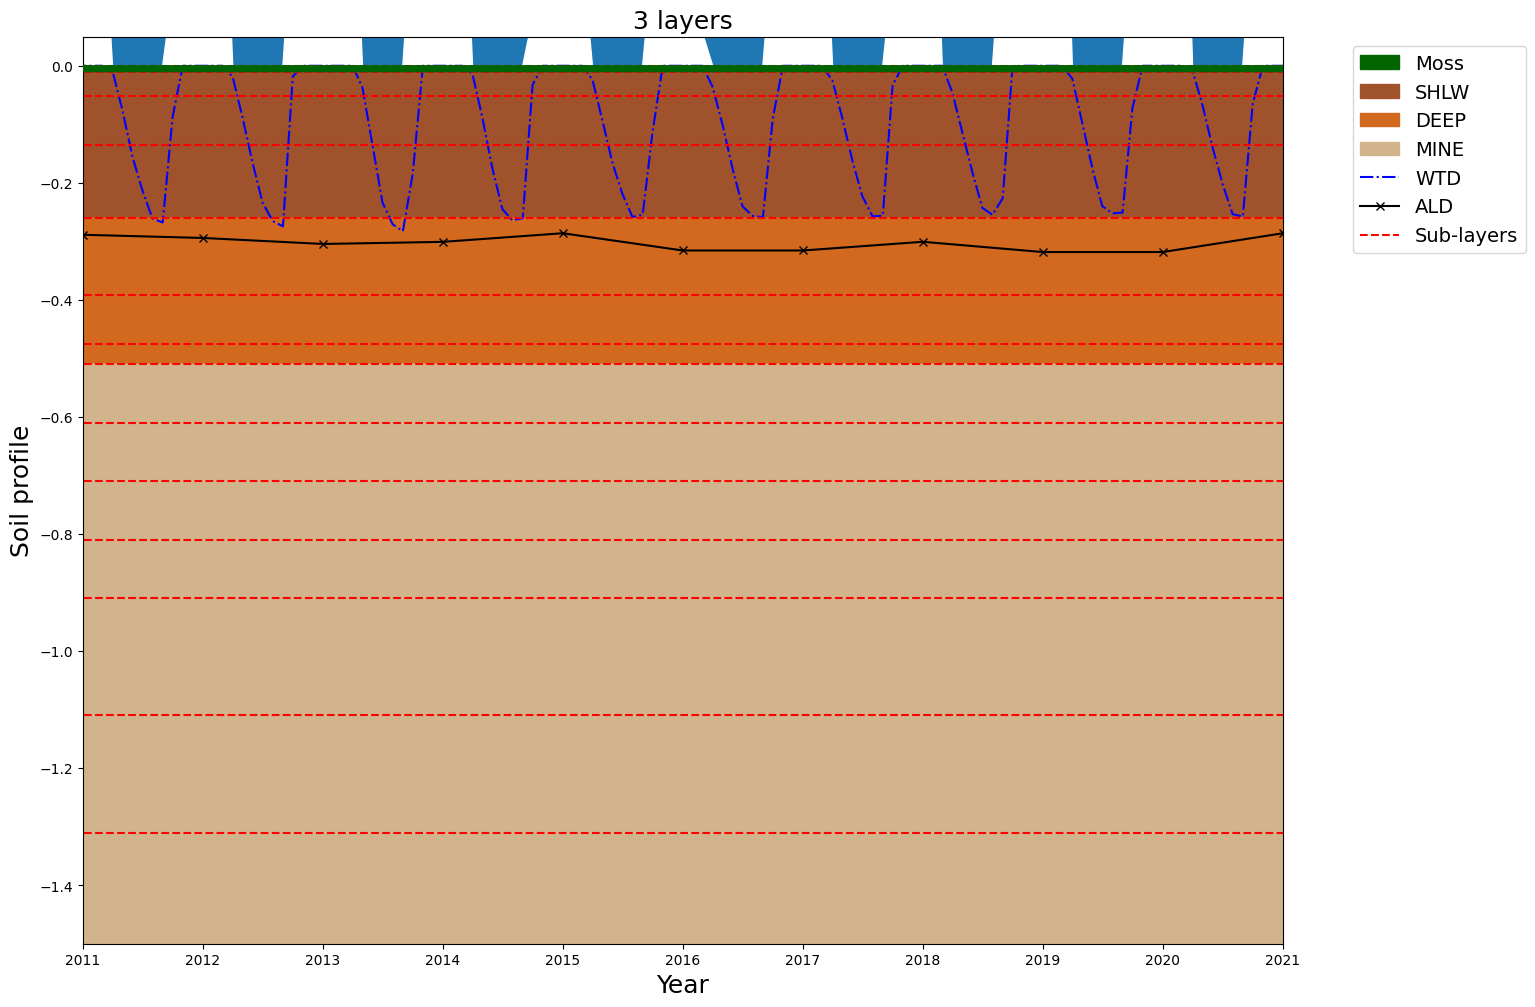

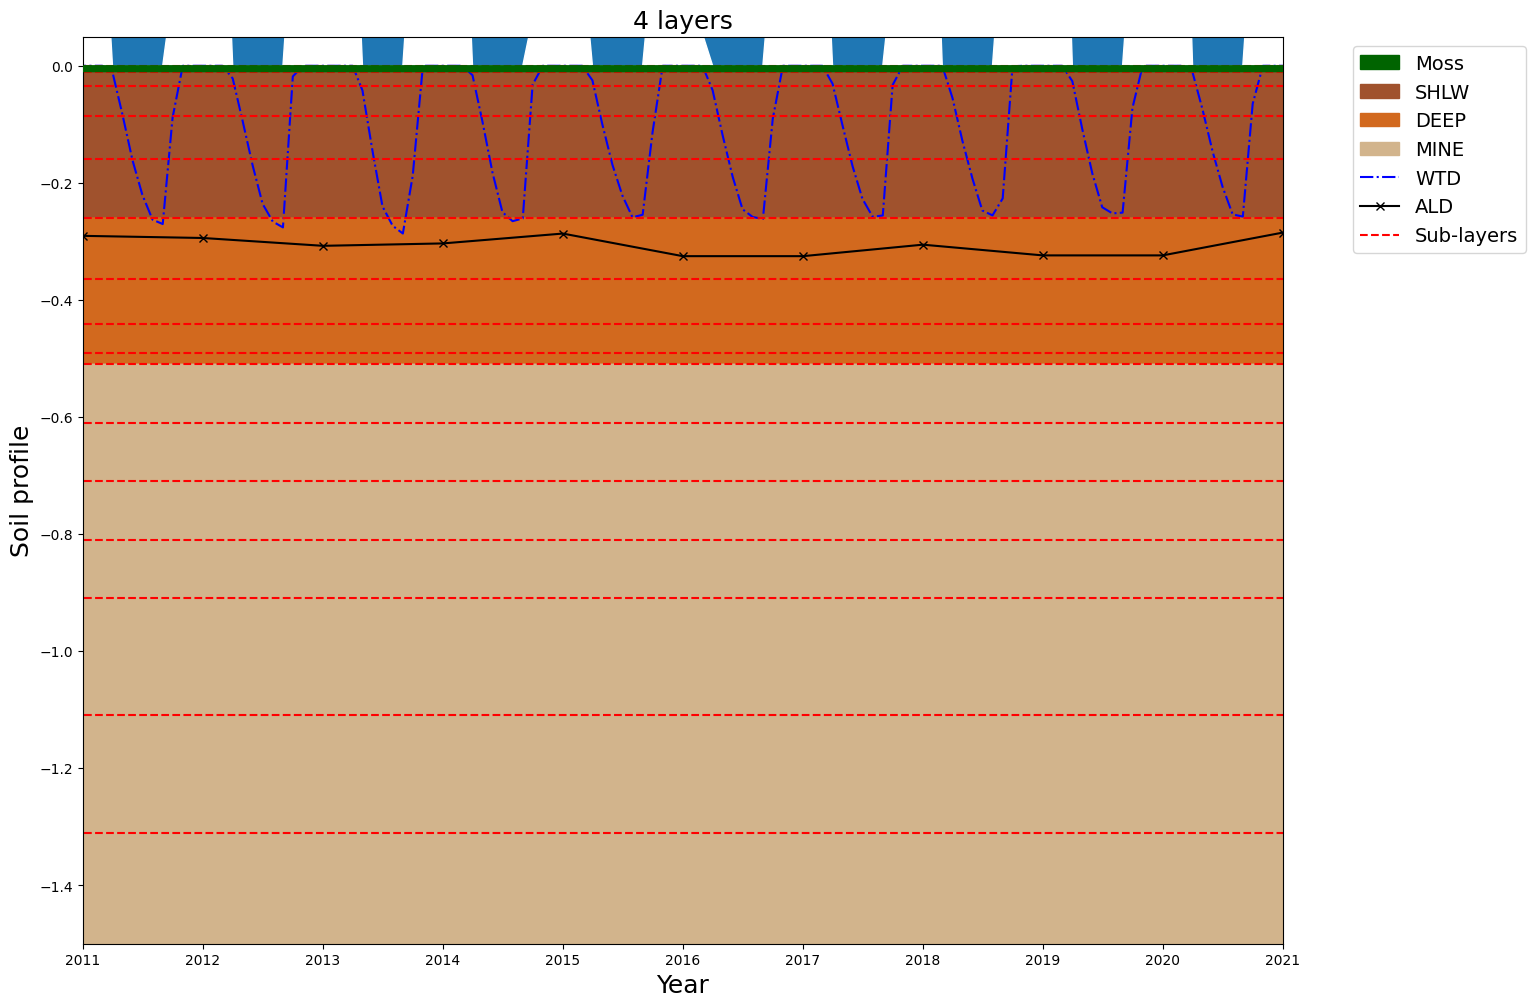

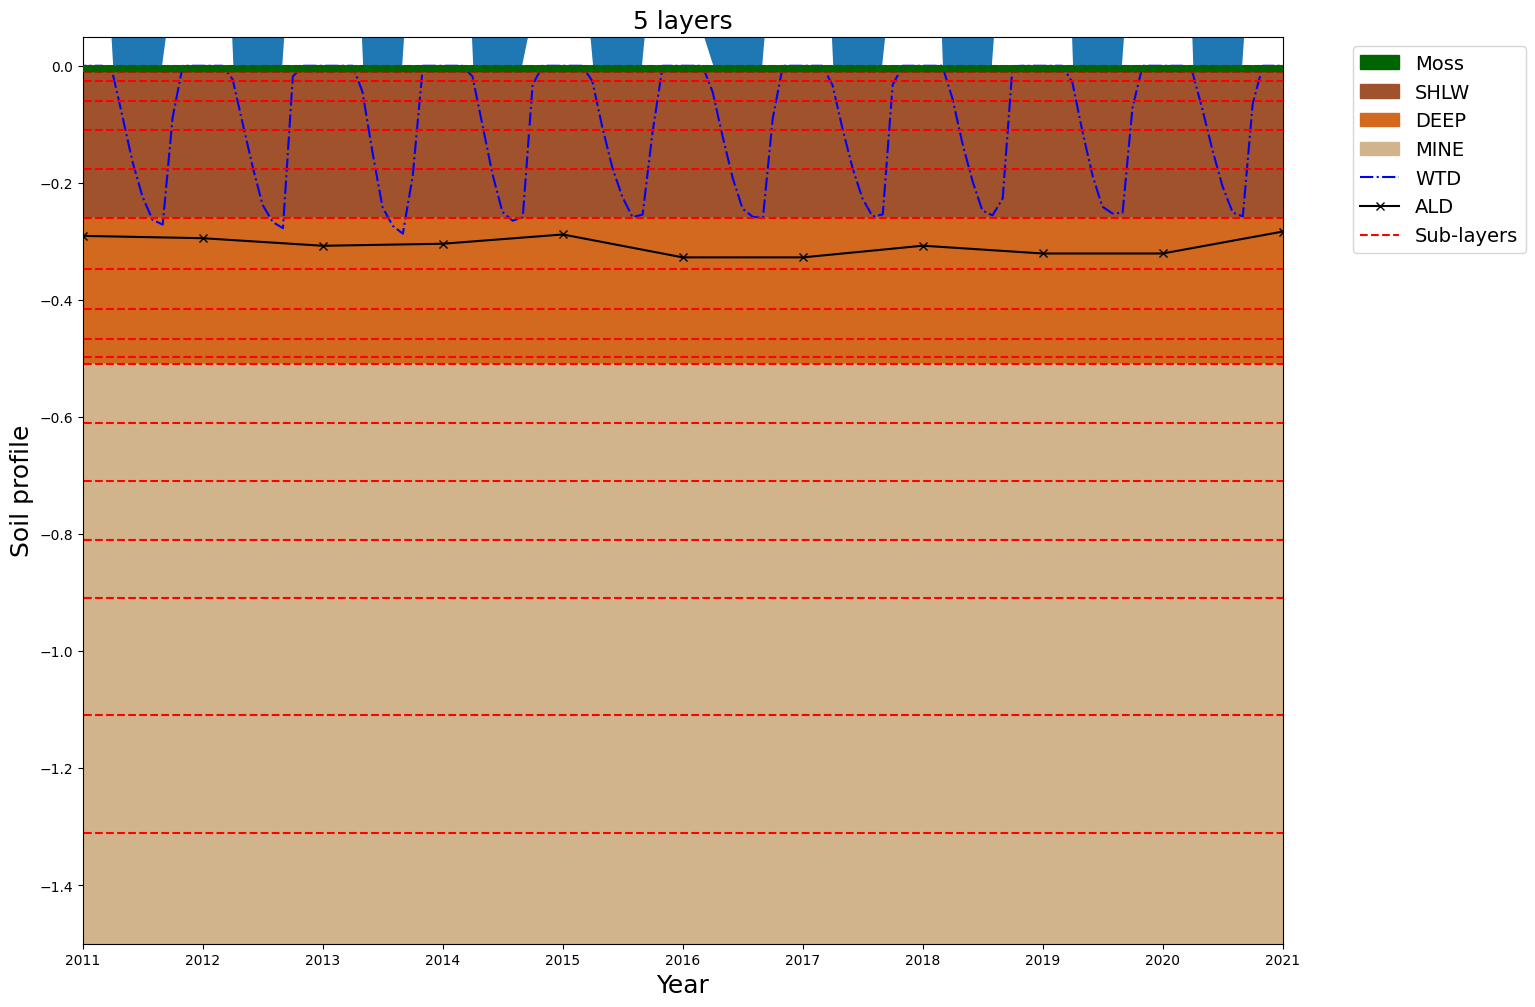

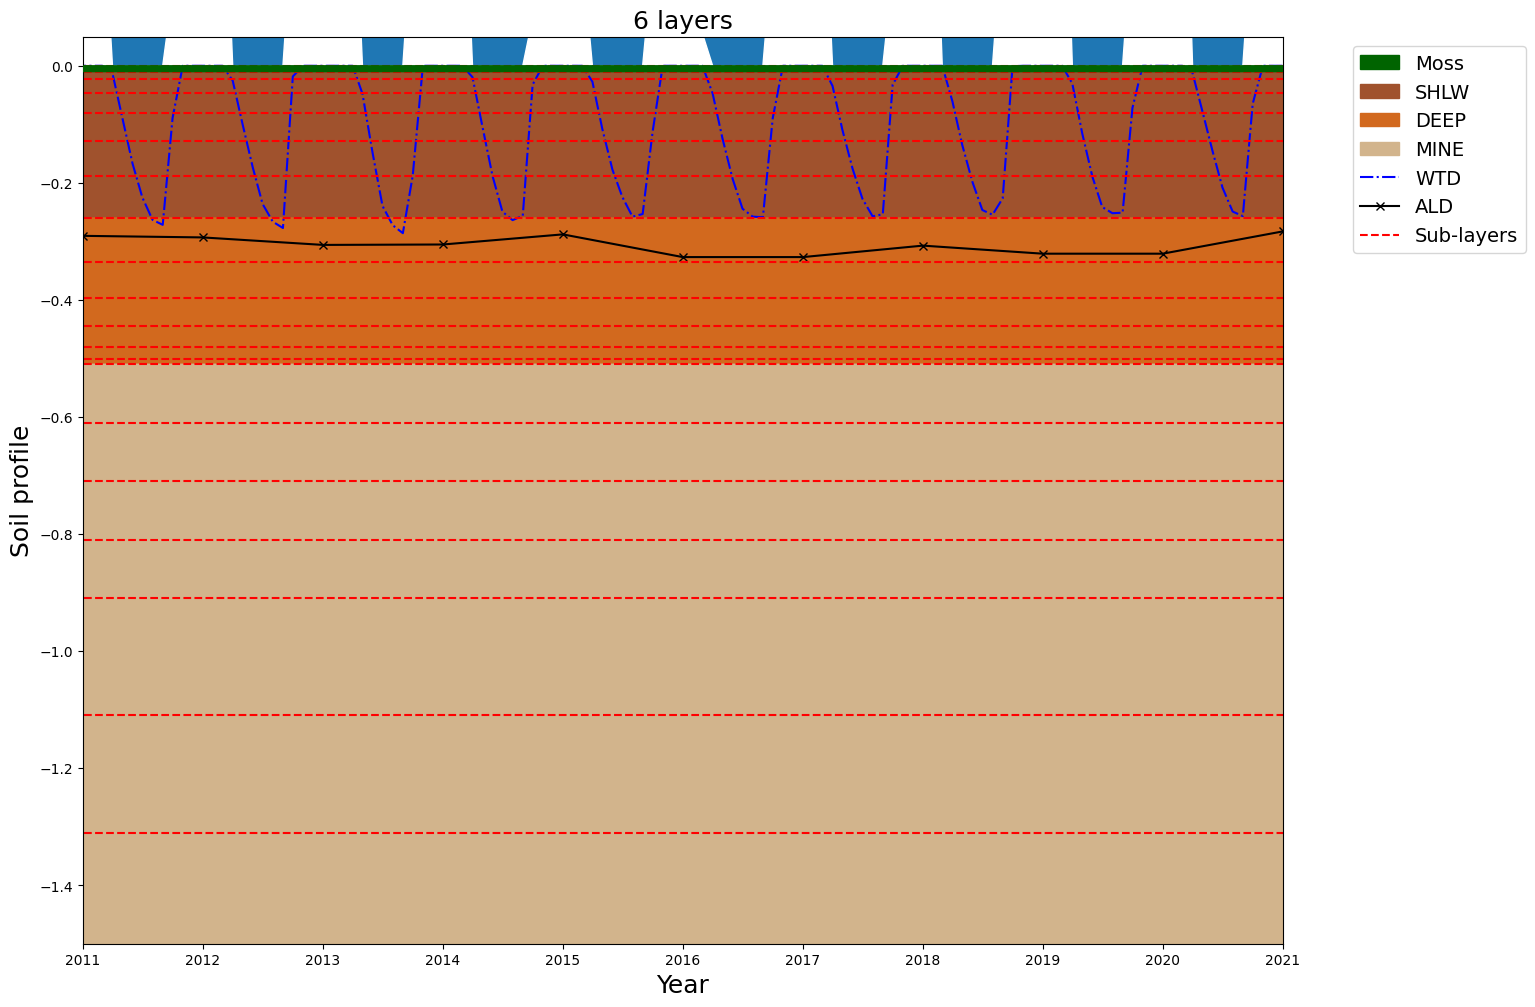

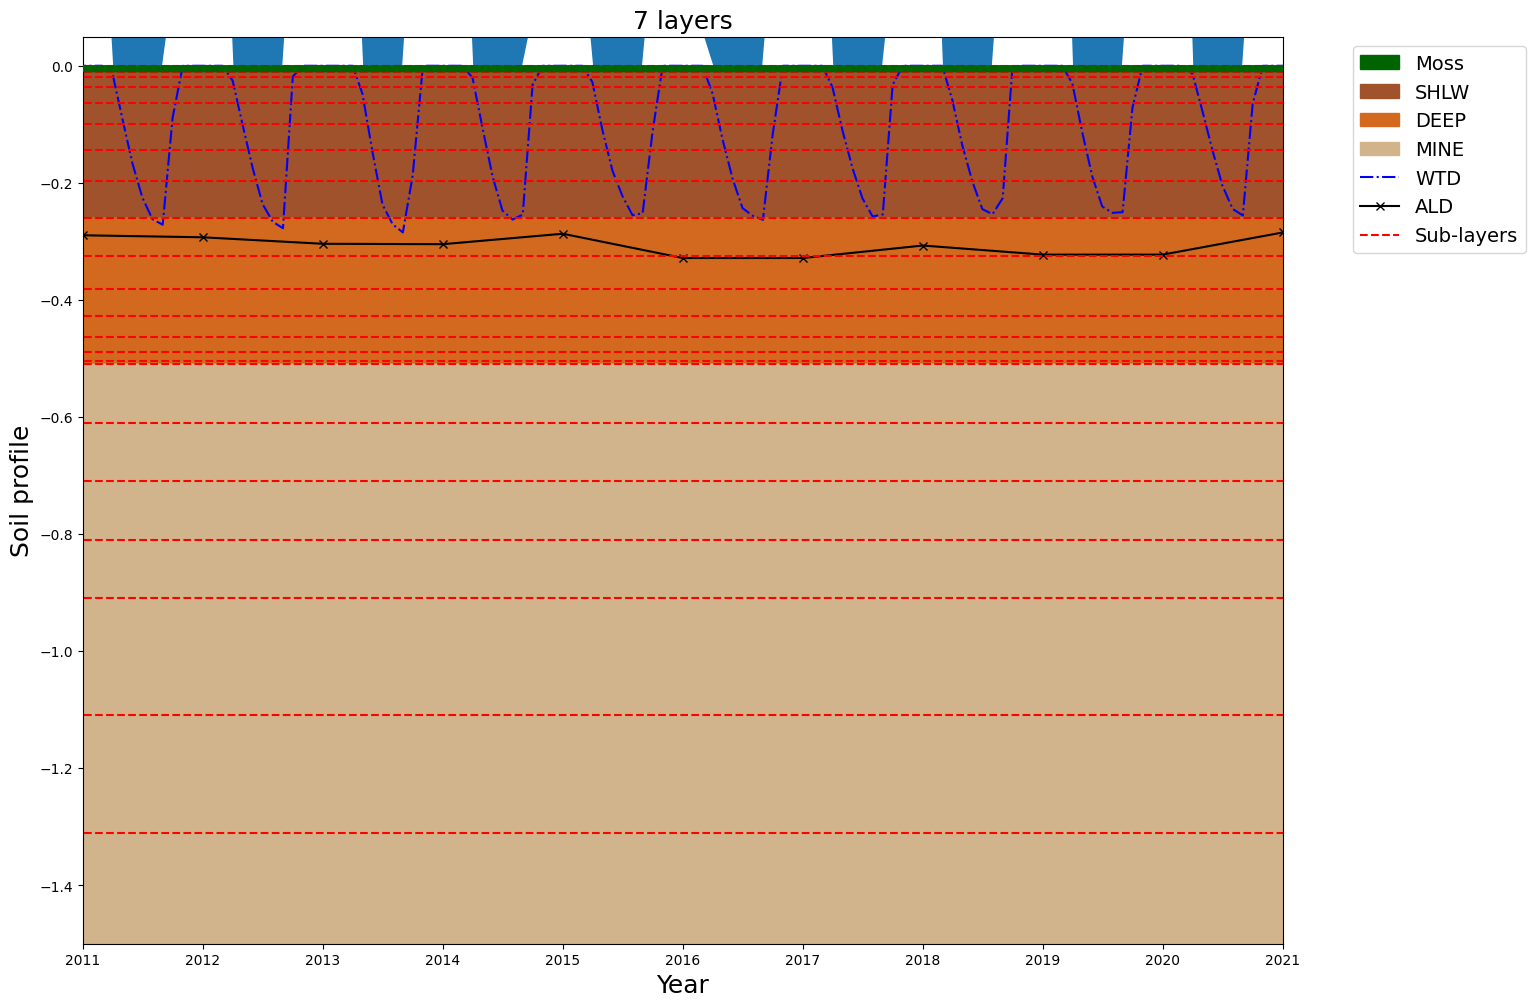

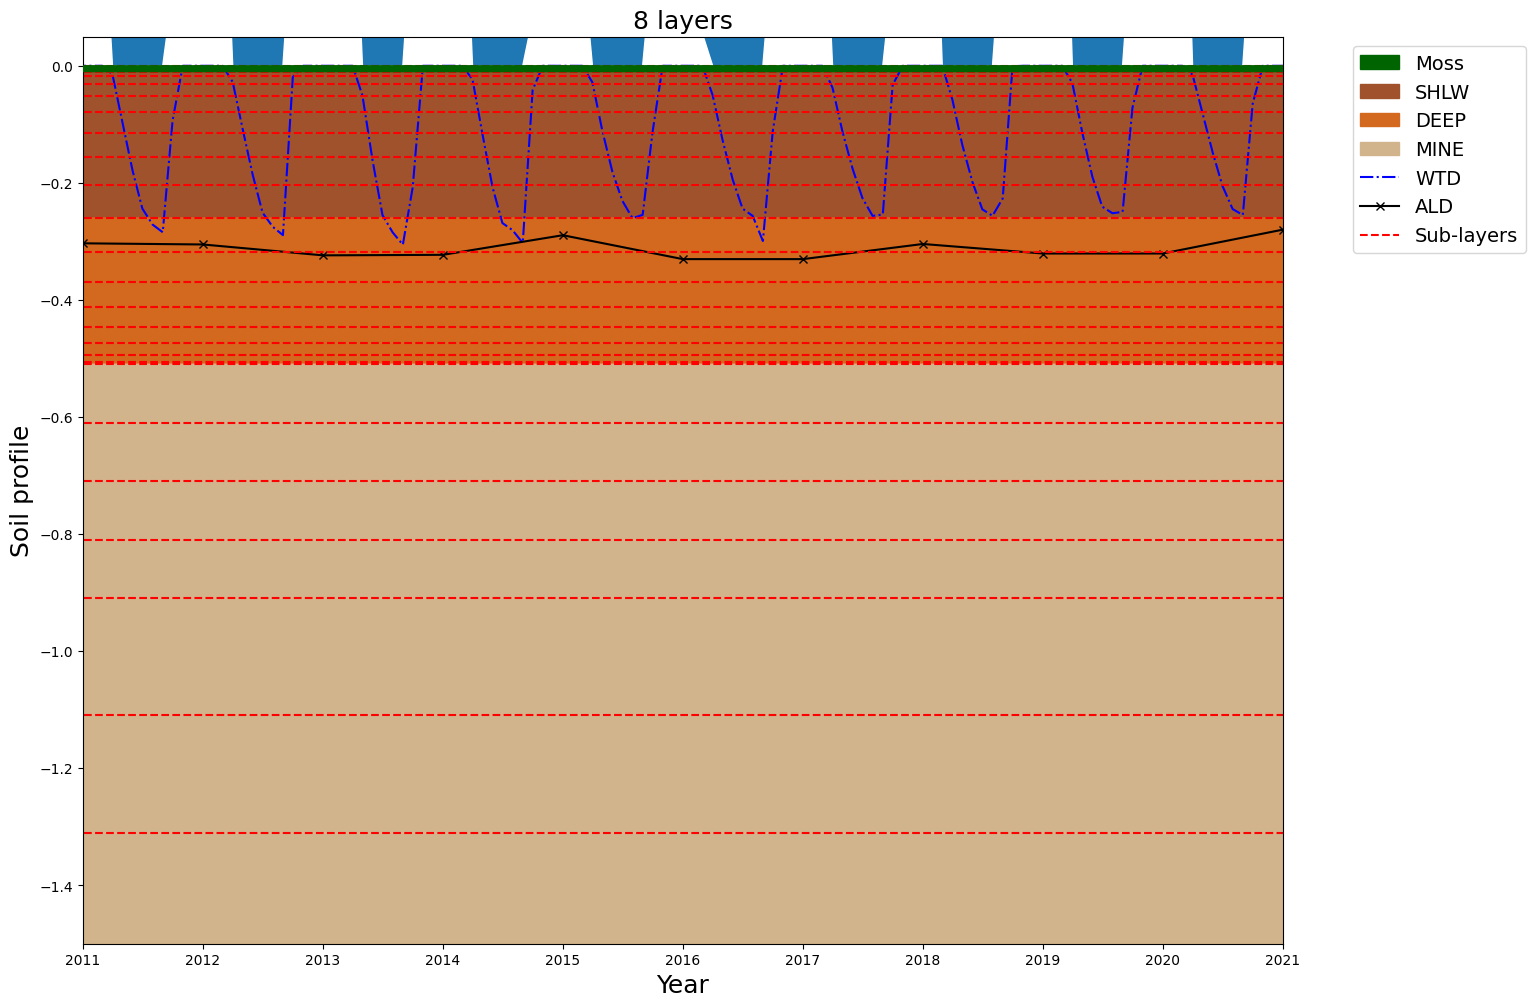

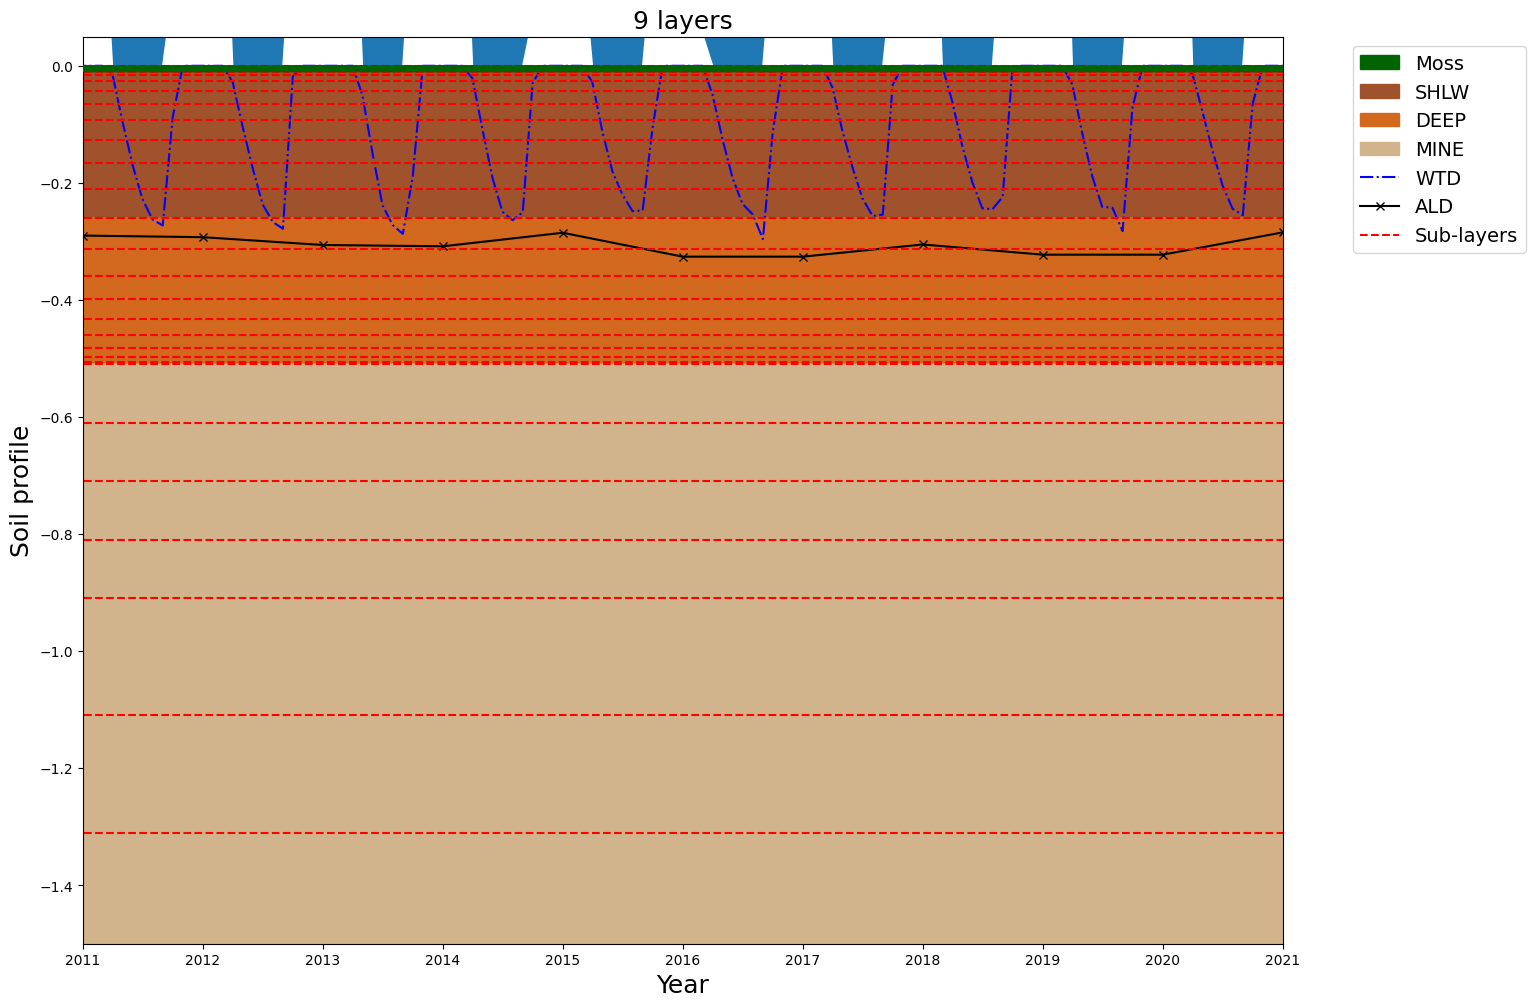

In [6]:
ymin = -1.5;  ymax = 0.05
xmin = datetime.date(2011,1,1);  xmax = datetime.date(2021,1,1)

for i in range(0, len(f_dir)): # each simulation is read in order of appearance within the monthly dataframe dfs_m
    
    fig, ax = plt.subplots()
    
    ax.set_facecolor('C0')
    
    ax.fill_between(dfs_m[i]["SNOWTHICK"].index, np.zeros(len(dfs_m[i]["SNOWTHICK"])), 
                    dfs_m[i]["SNOWTHICK"], color='white')
    
    ax.fill_between(soil_profiles["moss"][i].index, soil_profiles["moss"][i]["moss"], 
                    soil_profiles["ground"][i]["ground"],color="darkgreen", label='Moss', zorder=5)
    
    ax.fill_between(soil_profiles["shlw"][i].index, soil_profiles["shlw"][i]["shlw"], 
                    soil_profiles["moss"][i]["moss"],color="sienna", label='SHLW')
    
    ax.fill_between(soil_profiles["deep"][i].index, soil_profiles["deep"][i]["deep"], 
                    soil_profiles["shlw"][i]["shlw"],color="chocolate", label='DEEP')
    
    ax.fill_between(soil_profiles["mine"][i].index, soil_profiles["mine"][i]["mine"], 
                    soil_profiles["deep"][i]["deep"],color="tan", label='MINE')
    
    ax.plot(dfs_m[i]["WATERTAB"].index, -dfs_m[i]["WATERTAB"], 'b-.', label="WTD")
    
    ax.plot(dfs_y[i]["ALD"].index, -dfs_y[i]["ALD"], 'k-x', label="ALD")
    
    ax.plot(layer_data["LAYERDEPTH"][i].index, -layer_data["LAYERDEPTH"][i], 'r--')
    
    ax.set_ylim(ymin,ymax)
    ax.set_xlim(xmin, xmax)
    
    ax.set_xlabel('Year', fontsize=18)
    ax.set_ylabel('Soil profile', fontsize=18)
    
    ax.set_title(f_name[i], fontsize=18)
        
    handles, labels = plt.gca().get_legend_handles_labels()
    sub_layer_line = Line2D([0], [0], label='Sub-layers', color='red', linestyle='--')
    handles.extend([sub_layer_line])
    ax.legend(handles=handles, bbox_to_anchor=(1.05, 1.0), loc='upper left', fontsize=14)
    
    plt.subplots_adjust(left=None, bottom=None, right=2, top=2, wspace=None, hspace=None)
    
    plt.show()

In [14]:
vwcs=[]
tlayers=[]
n_layers=[]
for i in range(0, len(f_name)):
    vwc = layer_data["VWCLAYER"][i].mean(axis=None)
    vwcs.append(vwc)
    
    tlayer = layer_data["TLAYER"][i].mean(axis=None)
    tlayers.append(tlayer)
    
    n_layers.append(i+1)

Text(0, 0.5, 'Average VWC')

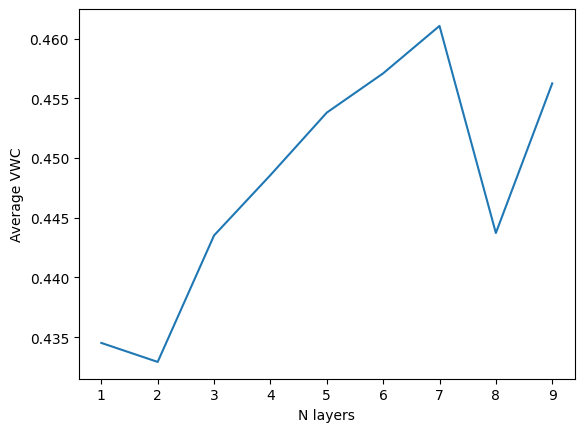

In [18]:
sns.lineplot(x=n_layers, y=vwcs)
plt.xlabel('N layers')
plt.ylabel('Average VWC')

Text(0, 0.5, 'Average Tlayer')

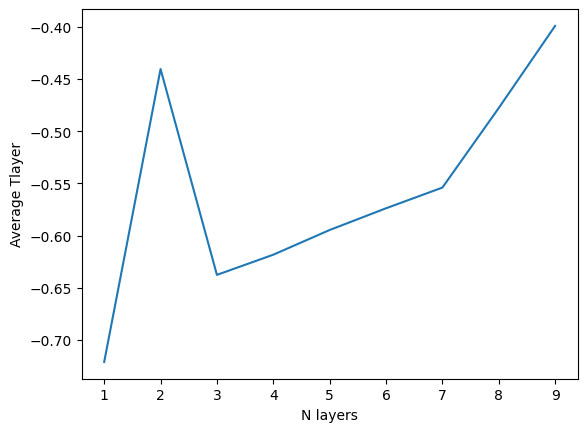

In [20]:
sns.lineplot(x=n_layers, y=tlayers)
plt.xlabel('N layers')
plt.ylabel('Average Tlayer')

(0.0, 0.5)

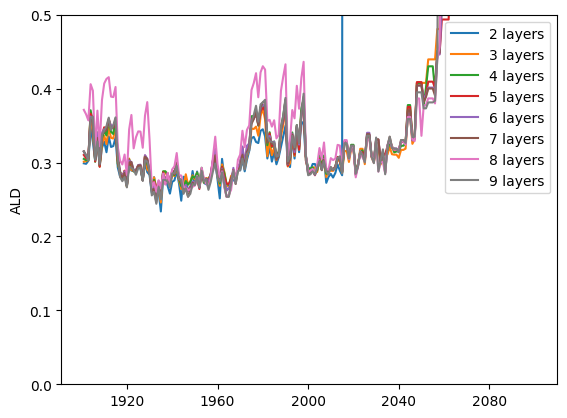

In [41]:
#sns.lineplot(x= dfs_y[0]["ALD"].index, y=dfs_y[0]["ALD"], label = '1 layers')
sns.lineplot(x= dfs_y[1]["ALD"].index, y=dfs_y[1]["ALD"], label = '2 layers') 
sns.lineplot(x= dfs_y[2]["ALD"].index, y=dfs_y[2]["ALD"], label = '3 layers') 
sns.lineplot(x= dfs_y[3]["ALD"].index, y=dfs_y[3]["ALD"], label = '4 layers') 
sns.lineplot(x= dfs_y[4]["ALD"].index, y=dfs_y[4]["ALD"], label = '5 layers') 
sns.lineplot(x= dfs_y[5]["ALD"].index, y=dfs_y[5]["ALD"], label = '6 layers') 
sns.lineplot(x= dfs_y[6]["ALD"].index, y=dfs_y[6]["ALD"], label = '7 layers') 
sns.lineplot(x= dfs_y[7]["ALD"].index, y=dfs_y[7]["ALD"], label = '8 layers') 
sns.lineplot(x= dfs_y[8]["ALD"].index, y=dfs_y[8]["ALD"], label = '9 layers')

plt.ylim(0,0.5)

In [21]:
layer_data.keys()

dict_keys(['LAYERDZ', 'LAYERDEPTH', 'LAYERTYPE', 'VWCLAYER', 'TLAYER'])

# Seasonal layer profile

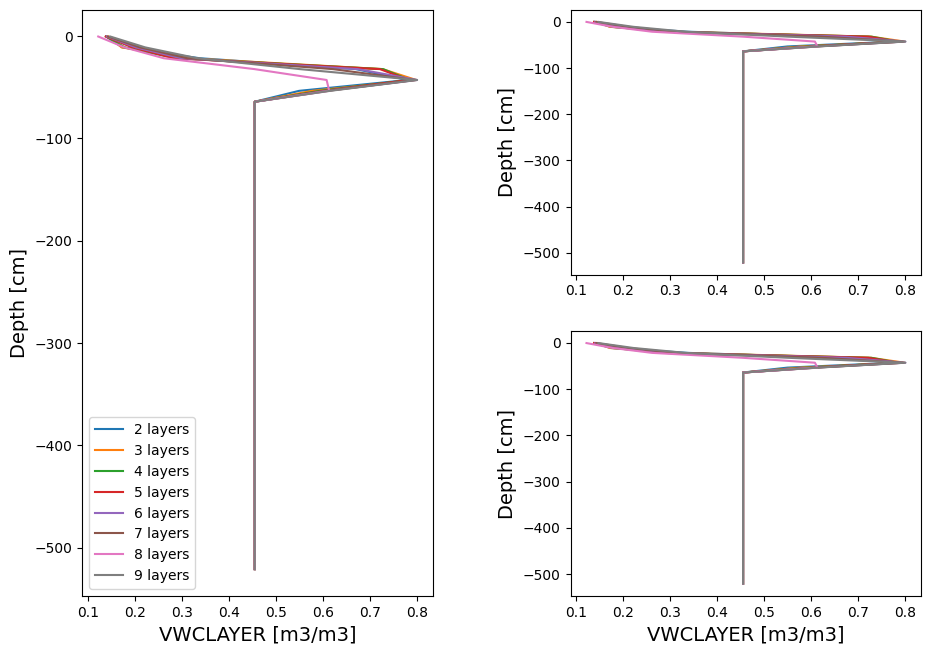

In [27]:
VAR = "VWCLAYER"

fig = plt.figure(1)
# set up subplot grid
gridspec.GridSpec(2,2)
# large subplot
plt.subplot2grid((2,2), (0,0), colspan=1, rowspan=2)
T_sum = []
for i in range(1, len(f_name)):
    
    layer_data["LAYERDEPTH"][i] + layer_data["LAYERDZ"][i]/2
    
    x, mean, std, mn, mx = seasonal_profile(layer_data[VAR][i],
                                            layer_data["LAYERDEPTH"][i],
                                            layer_data["LAYERDZ"][i],
                                            50, '2000-2010', 
                                            ['Jun', 'Jul', 'Aug',])
    
    T_sum.append(mean)
    
    plt.plot(mean, -x*100, label=f_name[i])

plt.xlabel(VAR+' ['+units[VAR]+']', fontsize=14)
plt.ylabel("Depth [cm]", fontsize=14)
plt.legend(loc="lower left", fontsize=10)



plt.subplot2grid((2,2), (0,1))

for i in range(1, len(f_name)):
    
    plt.plot(T_sum[i-1], -x*100, label=f_name[i])

plt.ylabel("Depth [cm]", fontsize=14)
# plt.xlim(-14,-9);plt.ylim(-50,0)

plt.subplot2grid((2,2), (1,1))

for i in range(1, len(f_name)):
    
    plt.plot(T_sum[i-1], -x*100, label=f_name[i])

plt.xlabel(VAR+' ['+units[VAR]+']', fontsize=14)
plt.ylabel("Depth [cm]", fontsize=14)
# plt.xlim(-10,-4);plt.ylim(-450,-80)

fig.tight_layout()
fig.set_size_inches(w=10,h=7)
# fig.savefig("/data/workflows/layer_scheme_test/winter_temperature_variation.png", bbox_inches="tight")

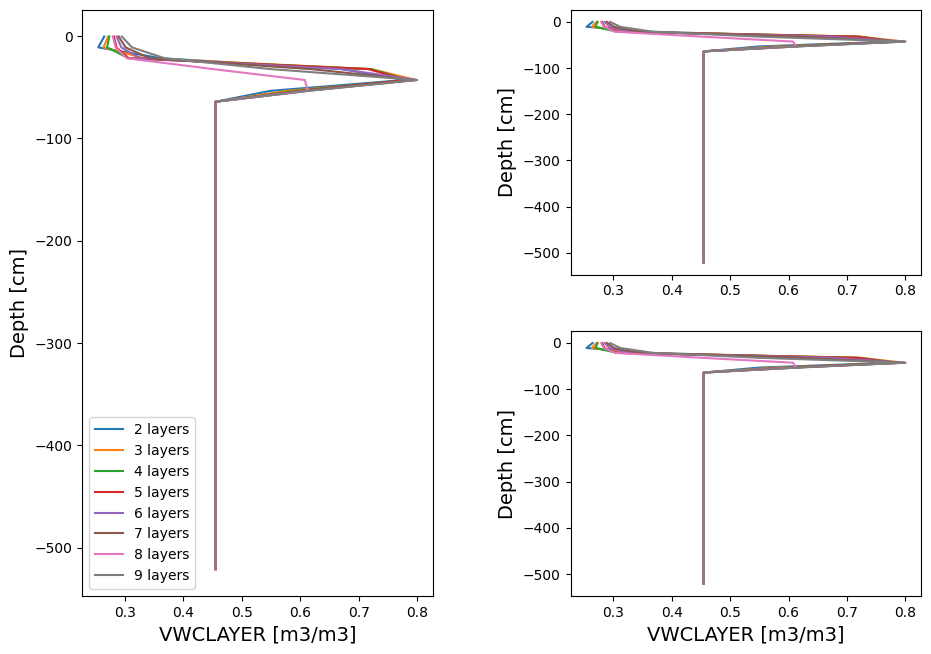

In [31]:
VAR = "VWCLAYER"

fig = plt.figure(1)
# set up subplot grid
gridspec.GridSpec(2,2)
# large subplot
plt.subplot2grid((2,2), (0,0), colspan=1, rowspan=2)
T_sum = []
for i in range(1, len(f_name)):
    
    layer_data["LAYERDEPTH"][i] + layer_data["LAYERDZ"][i]/2
    
    x, mean, std, mn, mx = seasonal_profile(layer_data[VAR][i],
                                            layer_data["LAYERDEPTH"][i],
                                            layer_data["LAYERDZ"][i],
                                            50, '2000-2010', 
                                            ['Jan', 'Feb', 'Mar'])
    
    T_sum.append(mean)
    
    plt.plot(mean, -x*100, label=f_name[i])

plt.xlabel(VAR+' ['+units[VAR]+']', fontsize=14)
plt.ylabel("Depth [cm]", fontsize=14)
plt.legend(loc="lower left", fontsize=10)



plt.subplot2grid((2,2), (0,1))

for i in range(1, len(f_name)):
    
    plt.plot(T_sum[i-1], -x*100, label=f_name[i])

plt.ylabel("Depth [cm]", fontsize=14)
# plt.xlim(-14,-9);plt.ylim(-50,0)

plt.subplot2grid((2,2), (1,1))

for i in range(1, len(f_name)):
    
    plt.plot(T_sum[i-1], -x*100, label=f_name[i])

plt.xlabel(VAR+' ['+units[VAR]+']', fontsize=14)
plt.ylabel("Depth [cm]", fontsize=14)
# plt.xlim(-10,-4);plt.ylim(-450,-80)

fig.tight_layout()
fig.set_size_inches(w=10,h=7)
# fig.savefig("/data/workflows/layer_scheme_test/winter_temperature_variation.png", bbox_inches="tight")

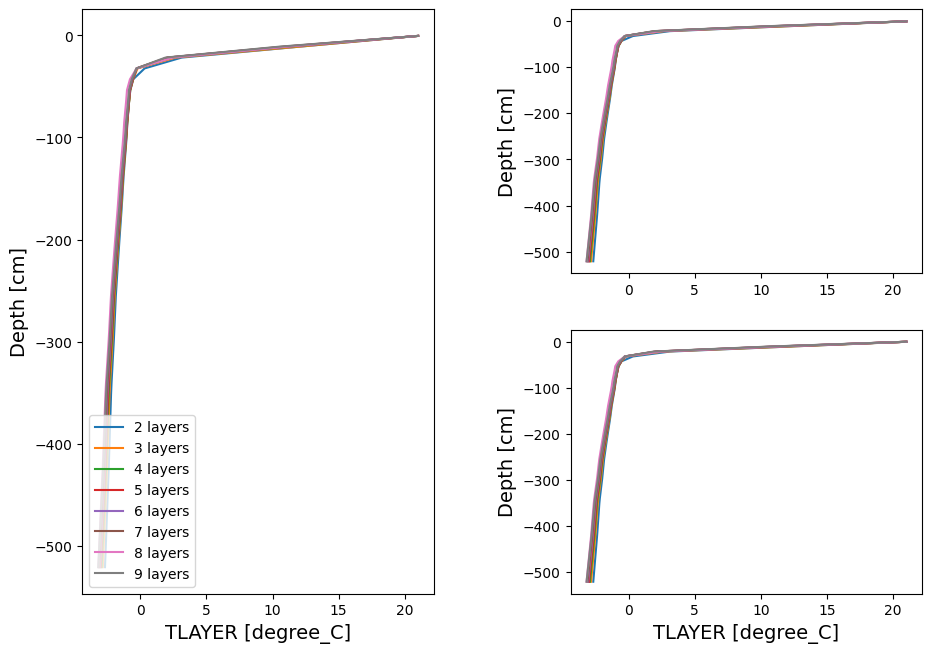

In [30]:
VAR = "TLAYER"

fig = plt.figure(1)
# set up subplot grid
gridspec.GridSpec(2,2)
# large subplot
plt.subplot2grid((2,2), (0,0), colspan=1, rowspan=2)
T_sum = []
for i in range(1, len(f_name)):
    
    x, mean, std, mn, mx = seasonal_profile(layer_data[VAR][i],
                                            layer_data["LAYERDEPTH"][i],
                                            layer_data["LAYERDZ"][i],
                                            50, '2000-2010', 
                                            ['Jun', 'Jul', 'Aug'])
    
    T_sum.append(mean)   
    
    plt.plot(mean, -x*100, label=f_name[i])

plt.xlabel(VAR+' ['+units[VAR]+']', fontsize=14)
plt.ylabel("Depth [cm]", fontsize=14)
plt.legend(loc="lower left", fontsize=10)

plt.subplot2grid((2,2), (0,1))
for i in range(1, len(f_name)):
    
    plt.plot(T_sum[i-1], -x*100, label=f_name[i])

plt.ylabel("Depth [cm]", fontsize=14)
# plt.xlim(-14,-9);plt.ylim(-50,0)

plt.subplot2grid((2,2), (1,1))
for i in range(1, len(f_name)):
    
    plt.plot(T_sum[i-1], -x*100, label=f_name[i])

plt.xlabel(VAR+' ['+units[VAR]+']', fontsize=14)
plt.ylabel("Depth [cm]", fontsize=14)
#plt.xlim(-10,-4);plt.ylim(-450,-80)

fig.tight_layout()
fig.set_size_inches(w=10,h=7)

# fig.savefig("/data/workflows/layer_scheme_test/winter_temperature_variation.png", bbox_inches="tight")

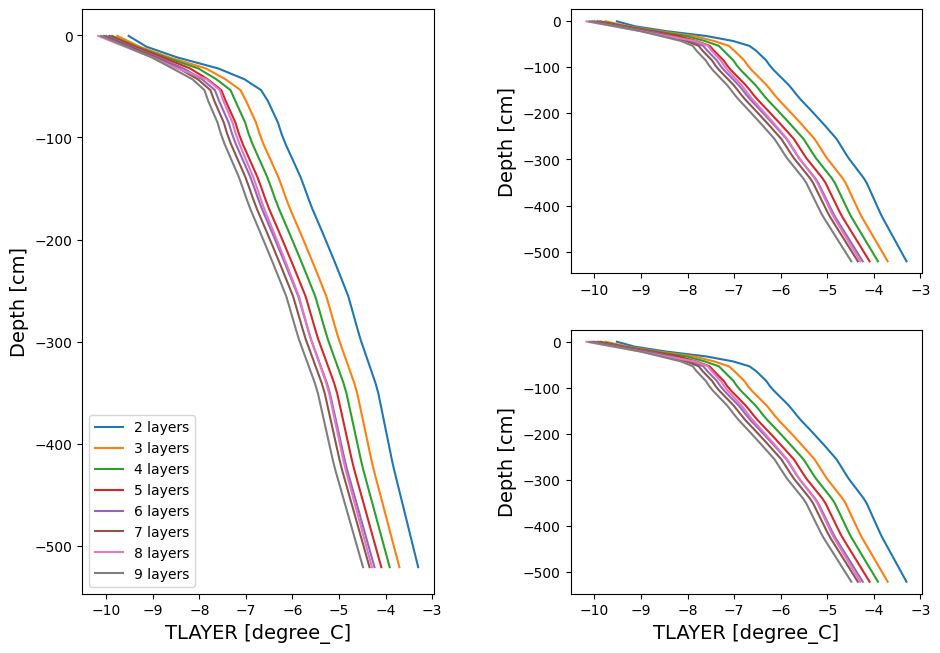

In [29]:
VAR = "TLAYER"

fig = plt.figure(1)
# set up subplot grid
gridspec.GridSpec(2,2)
# large subplot
plt.subplot2grid((2,2), (0,0), colspan=1, rowspan=2)
T_sum = []
for i in range(1, len(f_name)):
    
    x, mean, std, mn, mx = seasonal_profile(layer_data[VAR][i],
                                            layer_data["LAYERDEPTH"][i],
                                            layer_data["LAYERDZ"][i],
                                            50, '2000-2010', 
                                            ['Jan', 'Feb', 'Mar'])
    
    T_sum.append(mean)   
    
    plt.plot(mean, -x*100, label=f_name[i])

plt.xlabel(VAR+' ['+units[VAR]+']', fontsize=14)
plt.ylabel("Depth [cm]", fontsize=14)
plt.legend(loc="lower left", fontsize=10)

plt.subplot2grid((2,2), (0,1))
for i in range(1, len(f_name)):
    
    plt.plot(T_sum[i-1], -x*100, label=f_name[i])

plt.ylabel("Depth [cm]", fontsize=14)
# plt.xlim(-14,-9);plt.ylim(-50,0)

plt.subplot2grid((2,2), (1,1))
for i in range(1, len(f_name)):
    
    plt.plot(T_sum[i-1], -x*100, label=f_name[i])

plt.xlabel(VAR+' ['+units[VAR]+']', fontsize=14)
plt.ylabel("Depth [cm]", fontsize=14)
#plt.xlim(-10,-4);plt.ylim(-450,-80)

fig.tight_layout()
fig.set_size_inches(w=10,h=7)

# fig.savefig("/data/workflows/layer_scheme_test/winter_temperature_variation.png", bbox_inches="tight")

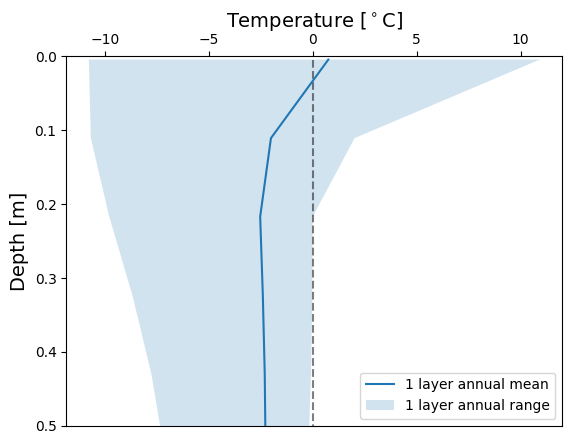

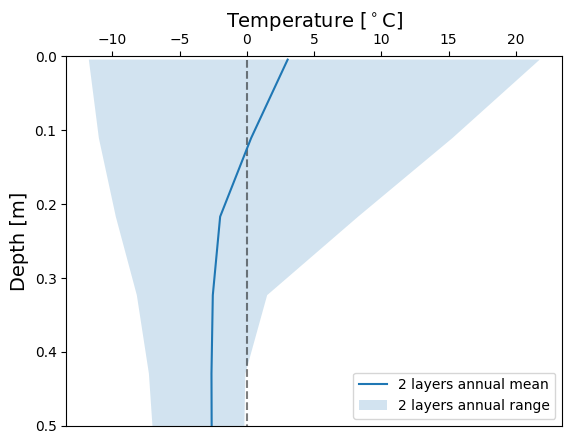

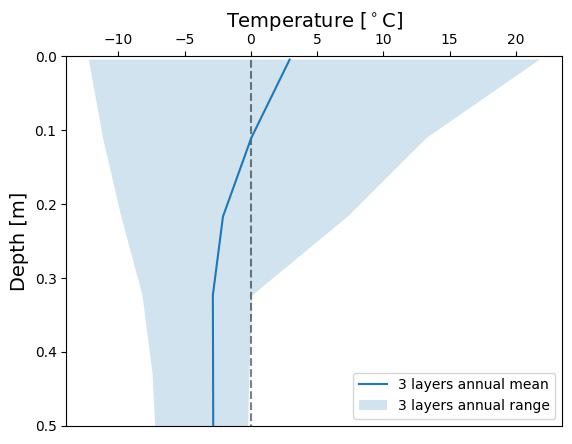

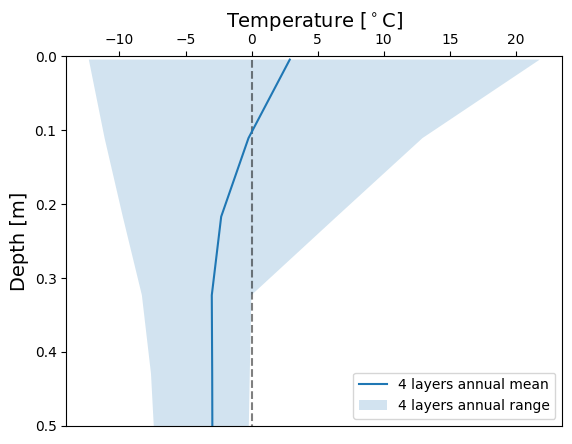

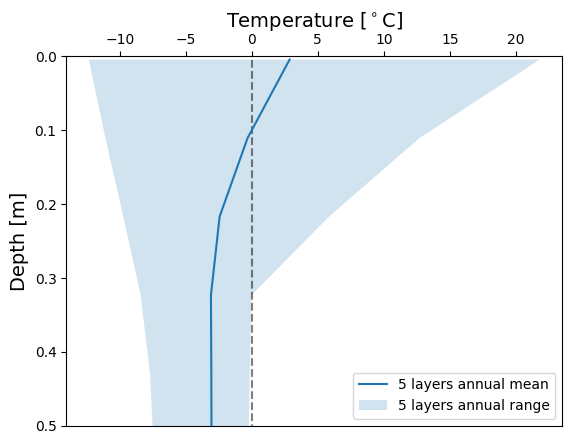

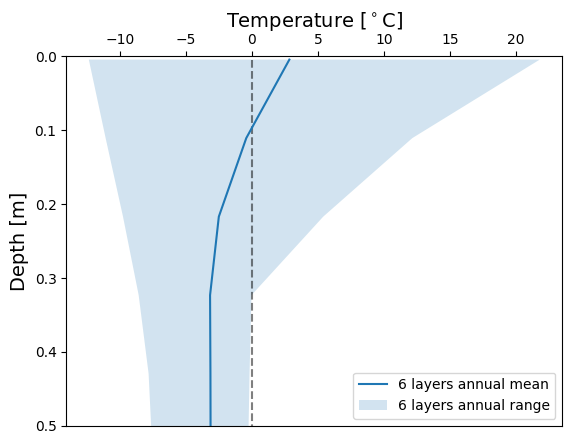

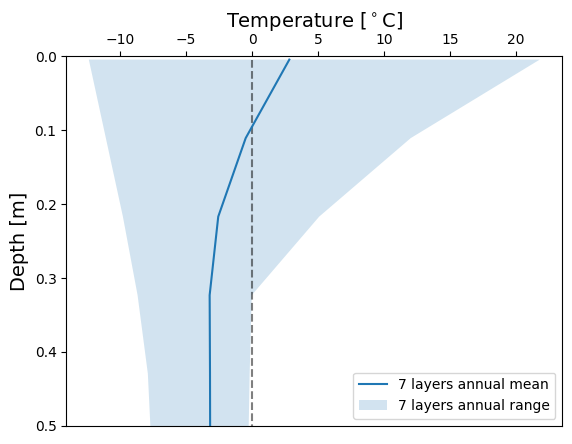

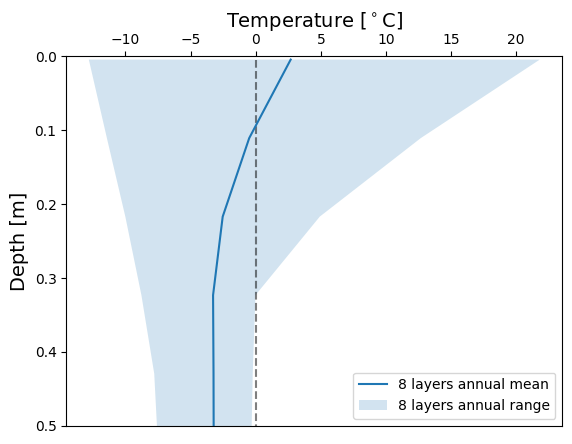

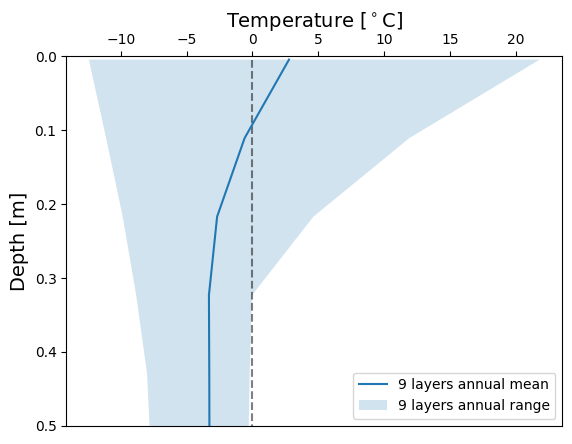

In [26]:

for i in range(0, len(f_name)):
    
    fig, ax = plt.subplots()
    x, mean, std, mn, mx = seasonal_profile(layer_data["TLAYER"][i],
                                            layer_data["LAYERDEPTH"][i],
                                            layer_data["LAYERDZ"][i],
                                            50,
                                            '2011-2012',
                                            ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'],)

    ax.plot(np.zeros(len(x)),x, 'k--', alpha=0.5)
    ax.plot(mean, x, label=f"{f_name[i]} annual mean")

    ax.fill_betweenx(x, mn, mx, alpha=0.2, label=f"{f_name[i]} annual range")
    plt.legend(loc="lower right", fontsize=10)

    ax.xaxis.tick_top()
    ax.set_xlabel(f"Temperature [$^\circ$C]", fontsize=14)
    ax.xaxis.set_label_position('top') 

    ax.set_ylabel(f"Depth [m]", fontsize=14)
    ax.set_ylim(0, .50)
    ax.invert_yaxis()
    plt.show()
    